In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data, prep_first_tract_data, reconstruction_loss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug



/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# FIRST TRACT DATASET
# NON VARIATIONAL 
# CONVOLUTIONAL AUTOENCODER
# TESTING DROPOUT VALUES

In [2]:
from afqinsight.nn.pt_models import Conv1DAutoencoder

In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [4]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [5]:
def train_first_tract_dropout_experiment(
    self, train_data, val_data, epochs=20, lr=0.001
):
    opt = torch.optim.Adam(self.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        self.train()
        running_loss = 0
        running_rmse = 0
        items = 0
        
        for tract_data, _ in train_data:
            tract_data = tract_data.to(device)
            
            # Forward pass
            opt.zero_grad()
            x_hat = self(tract_data)
            
            # Calculate loss
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
            
            # Backward pass
            loss.backward()
            opt.step()
            
            items += tract_data.size(0)
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * tract_data.size(0)
            
        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        train_rmse_per_epoch.append(avg_train_rmse)
        
        # Validation
        self.eval()
        val_rmse = 0
        val_items = 0
        
        with torch.no_grad():
            for tract_data, _ in val_data:
                tract_data = tract_data.to(device)
                x_hat = self(tract_data)
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
                val_items += tract_data.size(0)
                val_rmse += batch_val_rmse.item() * tract_data.size(0)
                
        avg_val_rmse = val_rmse / val_items
        val_rmse_per_epoch.append(avg_val_rmse)
        
        if avg_val_rmse < best_val_loss:
            best_val_loss = avg_val_rmse
            
        print(f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}")
        
    return train_rmse_per_epoch, val_rmse_per_epoch, best_val_loss

In [6]:
torch_dataset, first_tract_train_loader, first_tract_test_loader, first_tract_val_loader = prep_first_tract_data(
    dataset, batch_size=64
)

In [7]:
dropout_values = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
train_rmse_results = {}
val_rmse_results = {}
best_val_results = {}


for dropout in dropout_values:
    print(f"\nTraining with dropout = {dropout}")
    vae_one_tract = Conv1DAutoencoder(latent_dims=20, dropout=dropout).to(device)
    train_rmse, val_rmse, best_val_loss = train_first_tract_dropout_experiment(
        vae_one_tract, first_tract_train_loader, first_tract_val_loader, epochs=100, lr=1e-3
    )
    train_rmse_results[dropout] = train_rmse
    val_rmse_results[dropout] = val_rmse
    best_val_results[dropout] = best_val_loss


Training with dropout = 0
Epoch 1, Train RMSE: 0.0924, Val RMSE: 0.0863
Epoch 2, Train RMSE: 0.0790, Val RMSE: 0.0722
Epoch 3, Train RMSE: 0.0593, Val RMSE: 0.0560
Epoch 4, Train RMSE: 0.0491, Val RMSE: 0.0503
Epoch 5, Train RMSE: 0.0429, Val RMSE: 0.0404
Epoch 6, Train RMSE: 0.0348, Val RMSE: 0.0334
Epoch 7, Train RMSE: 0.0291, Val RMSE: 0.0290
Epoch 8, Train RMSE: 0.0249, Val RMSE: 0.0243
Epoch 9, Train RMSE: 0.0213, Val RMSE: 0.0204
Epoch 10, Train RMSE: 0.0193, Val RMSE: 0.0184
Epoch 11, Train RMSE: 0.0173, Val RMSE: 0.0170
Epoch 12, Train RMSE: 0.0168, Val RMSE: 0.0162
Epoch 13, Train RMSE: 0.0163, Val RMSE: 0.0168
Epoch 14, Train RMSE: 0.0156, Val RMSE: 0.0150
Epoch 15, Train RMSE: 0.0145, Val RMSE: 0.0146
Epoch 16, Train RMSE: 0.0143, Val RMSE: 0.0140
Epoch 17, Train RMSE: 0.0138, Val RMSE: 0.0137
Epoch 18, Train RMSE: 0.0155, Val RMSE: 0.0157
Epoch 19, Train RMSE: 0.0142, Val RMSE: 0.0143
Epoch 20, Train RMSE: 0.0134, Val RMSE: 0.0131
Epoch 21, Train RMSE: 0.0125, Val RMSE: 0.

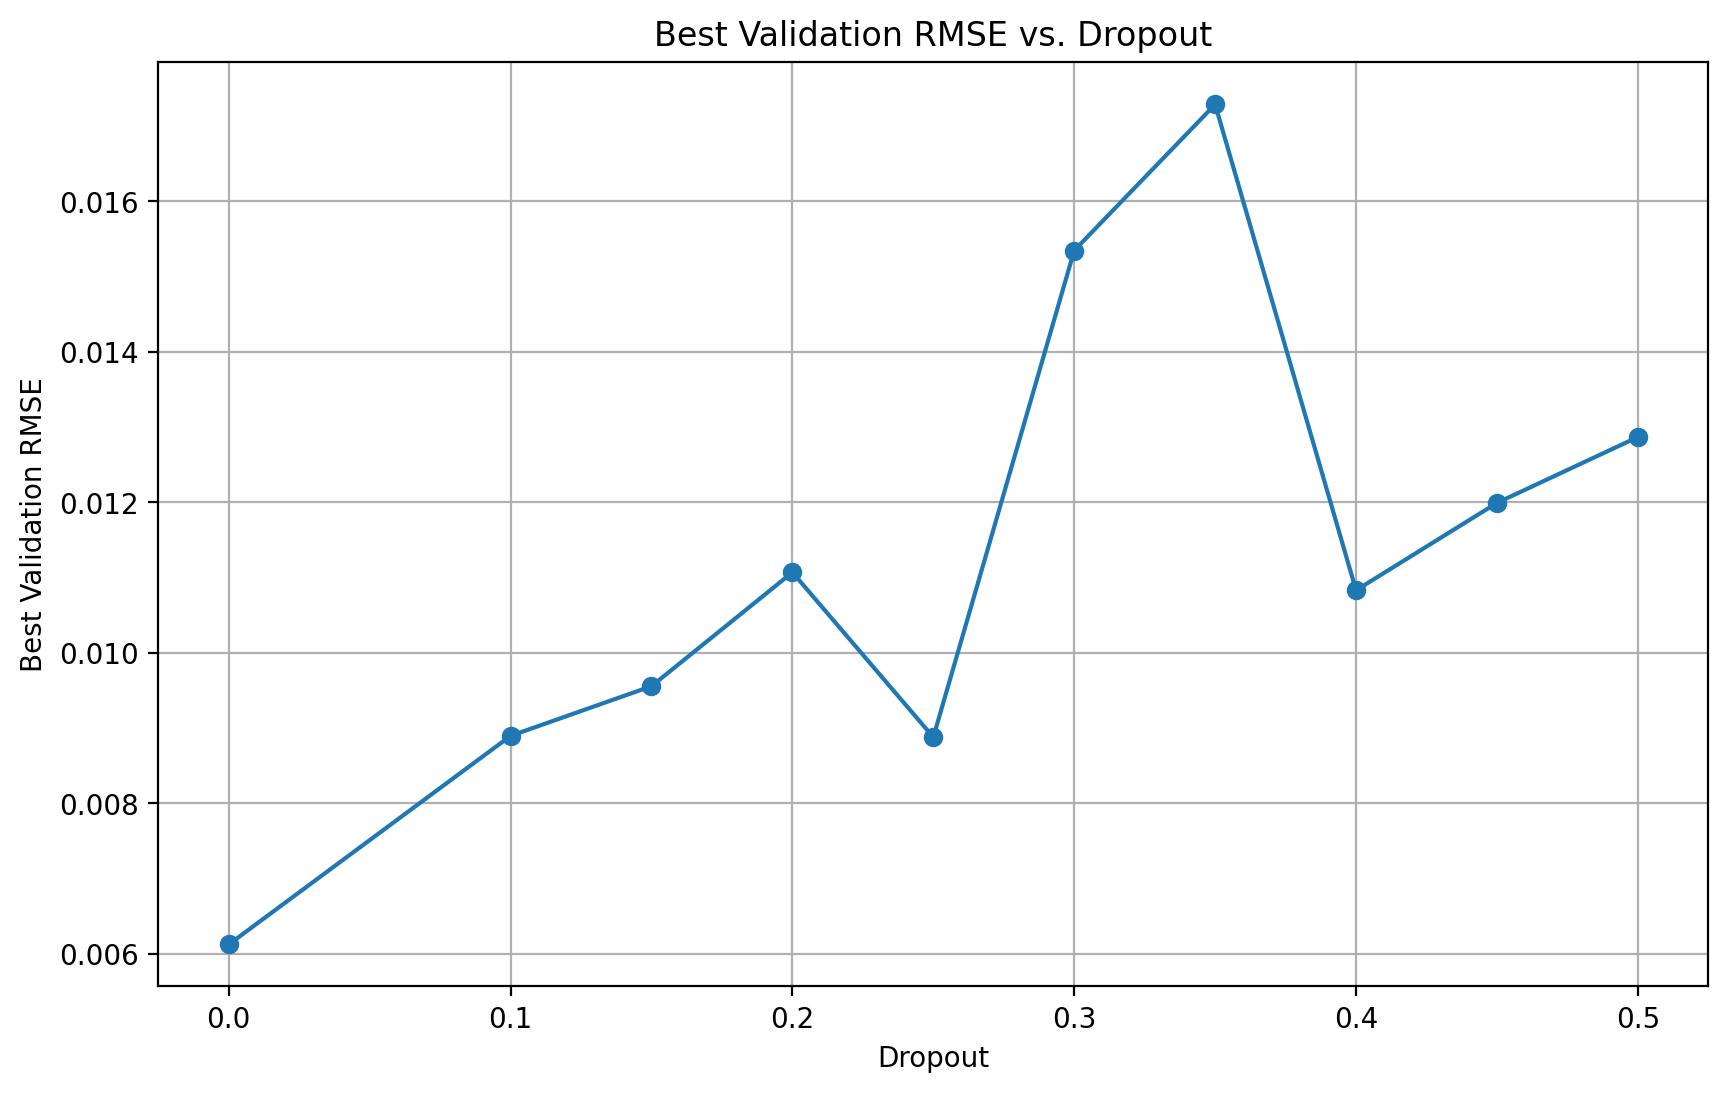

In [8]:
# Plot best validation RMSE for each dropout value
plt.figure(figsize=(10, 6))
dropout_keys = sorted(best_val_results.keys())
best_vals = [best_val_results[d] for d in dropout_keys]
plt.plot(dropout_keys, best_vals, marker='o')
plt.xlabel("Dropout")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Dropout")
plt.grid()
plt.show()



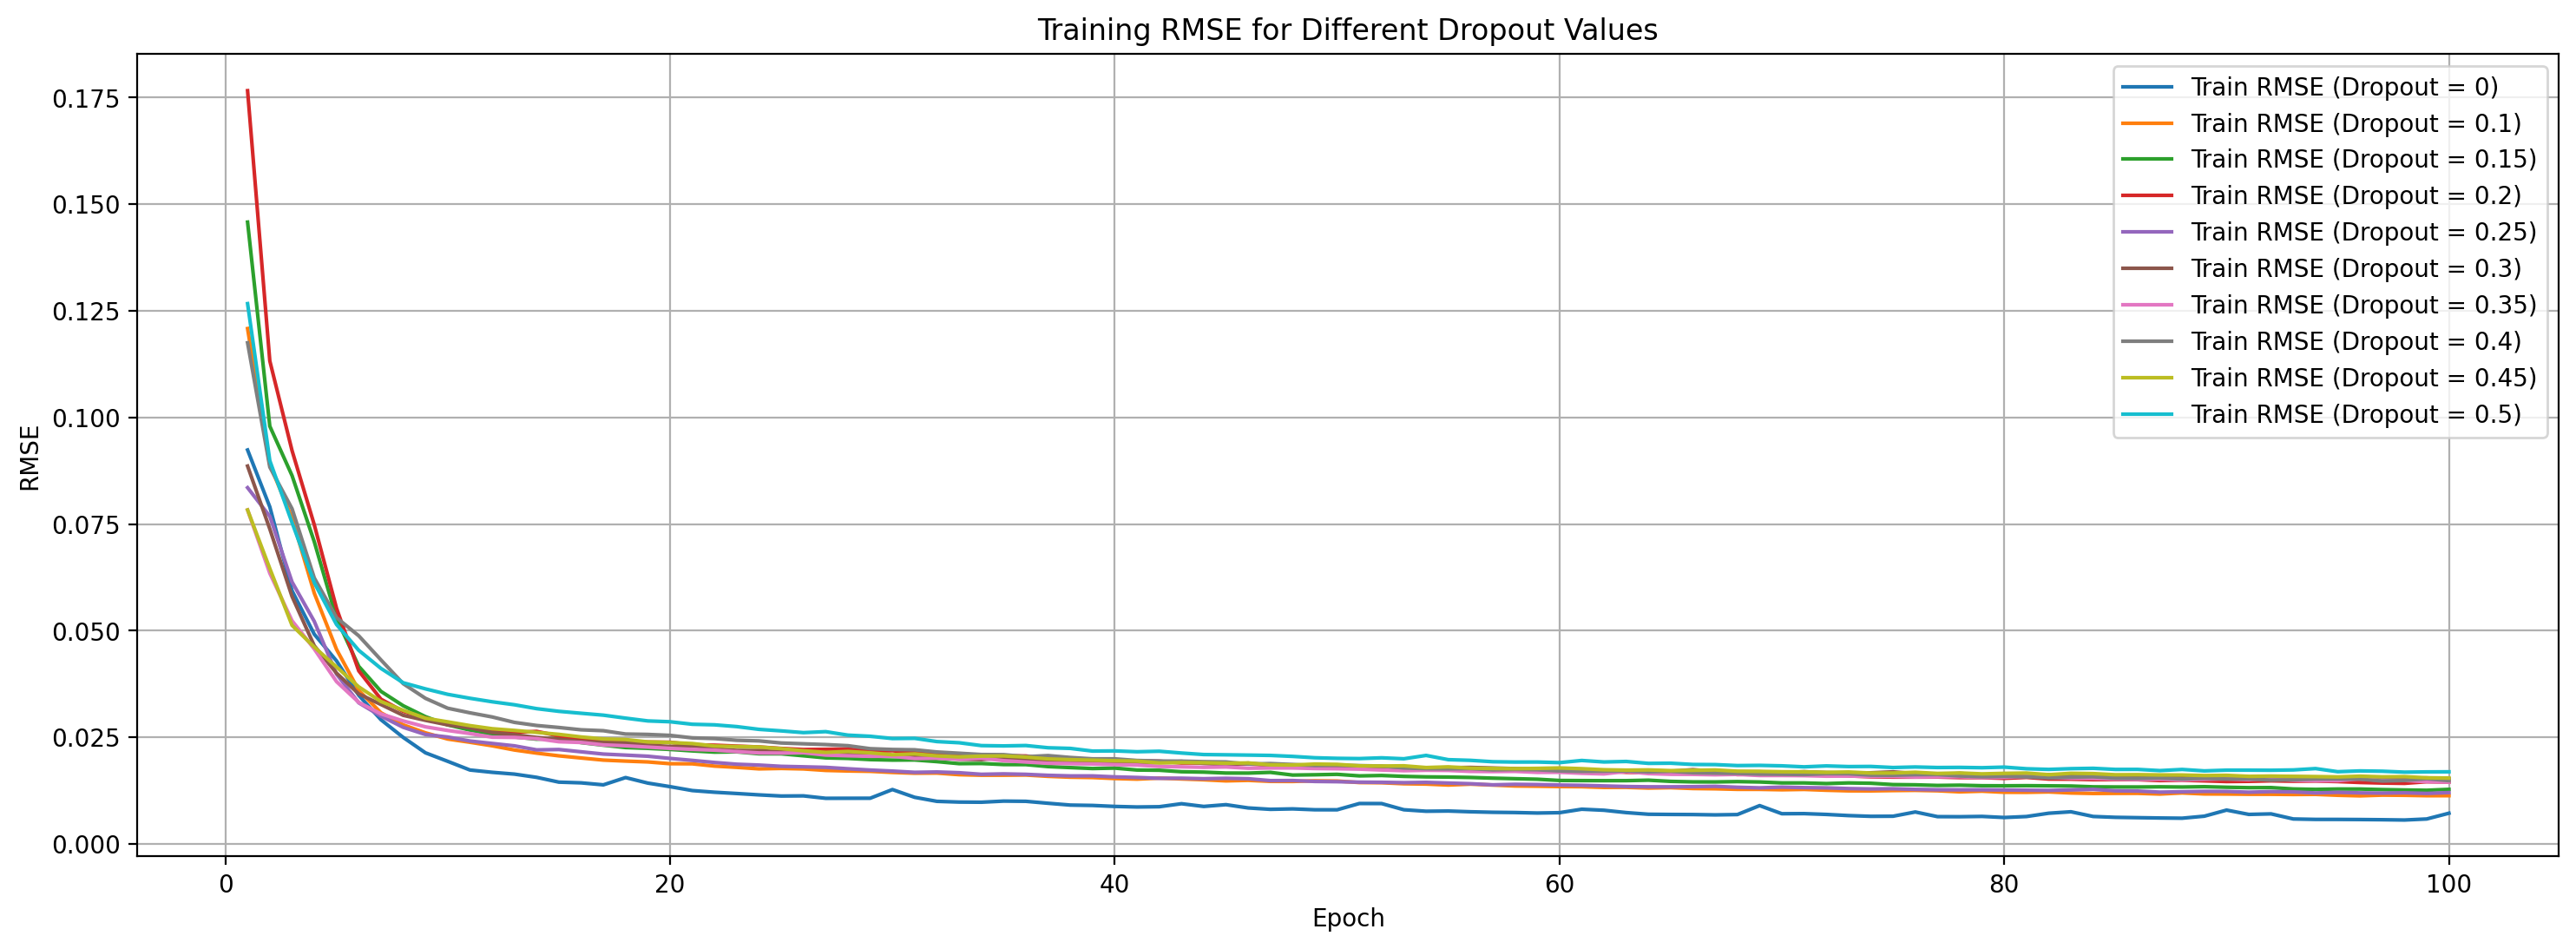

In [9]:
# Plot 1: Training RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()


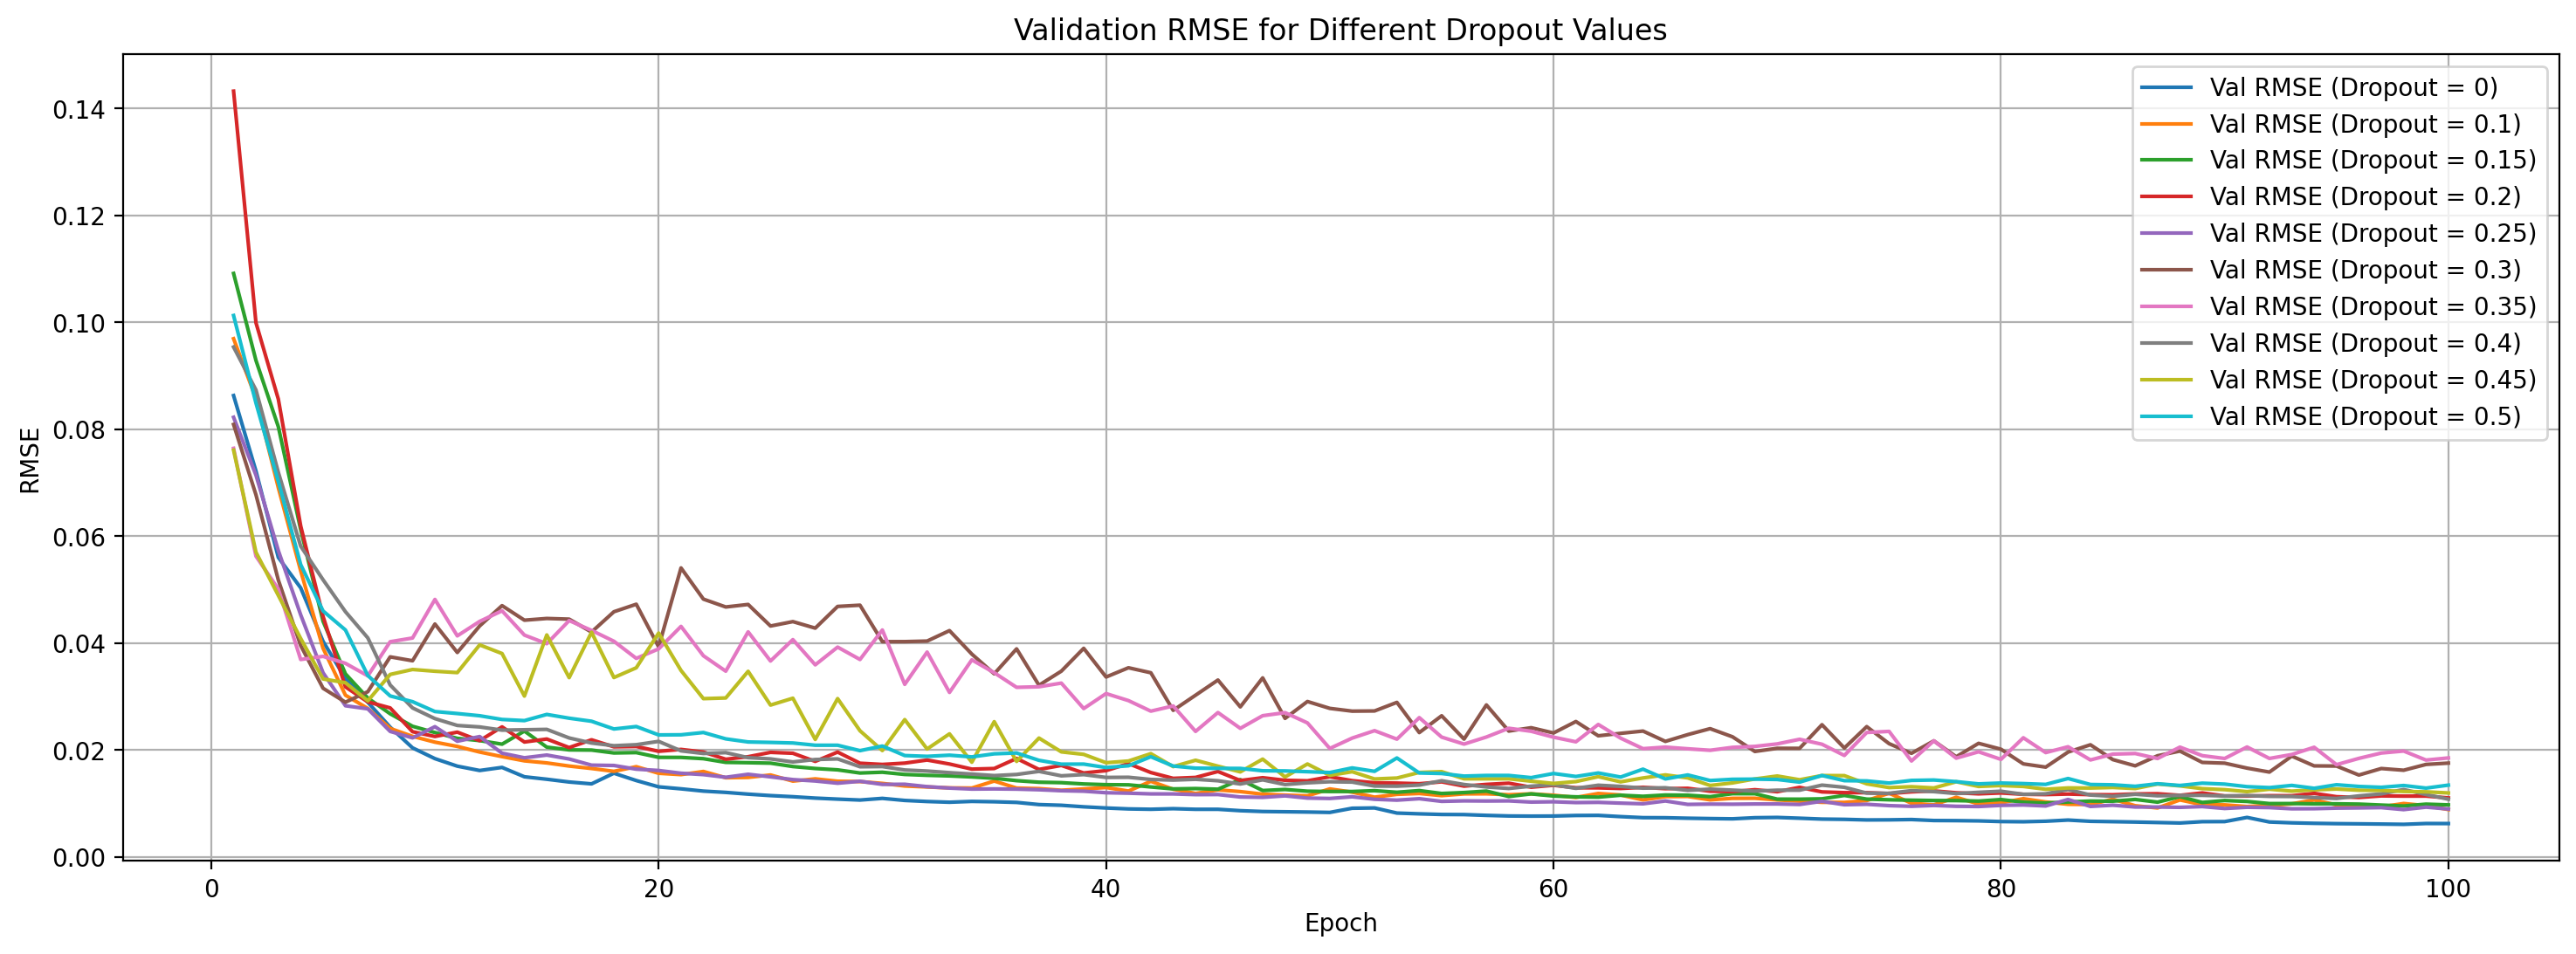

In [10]:
# Plot 2: Validation RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()


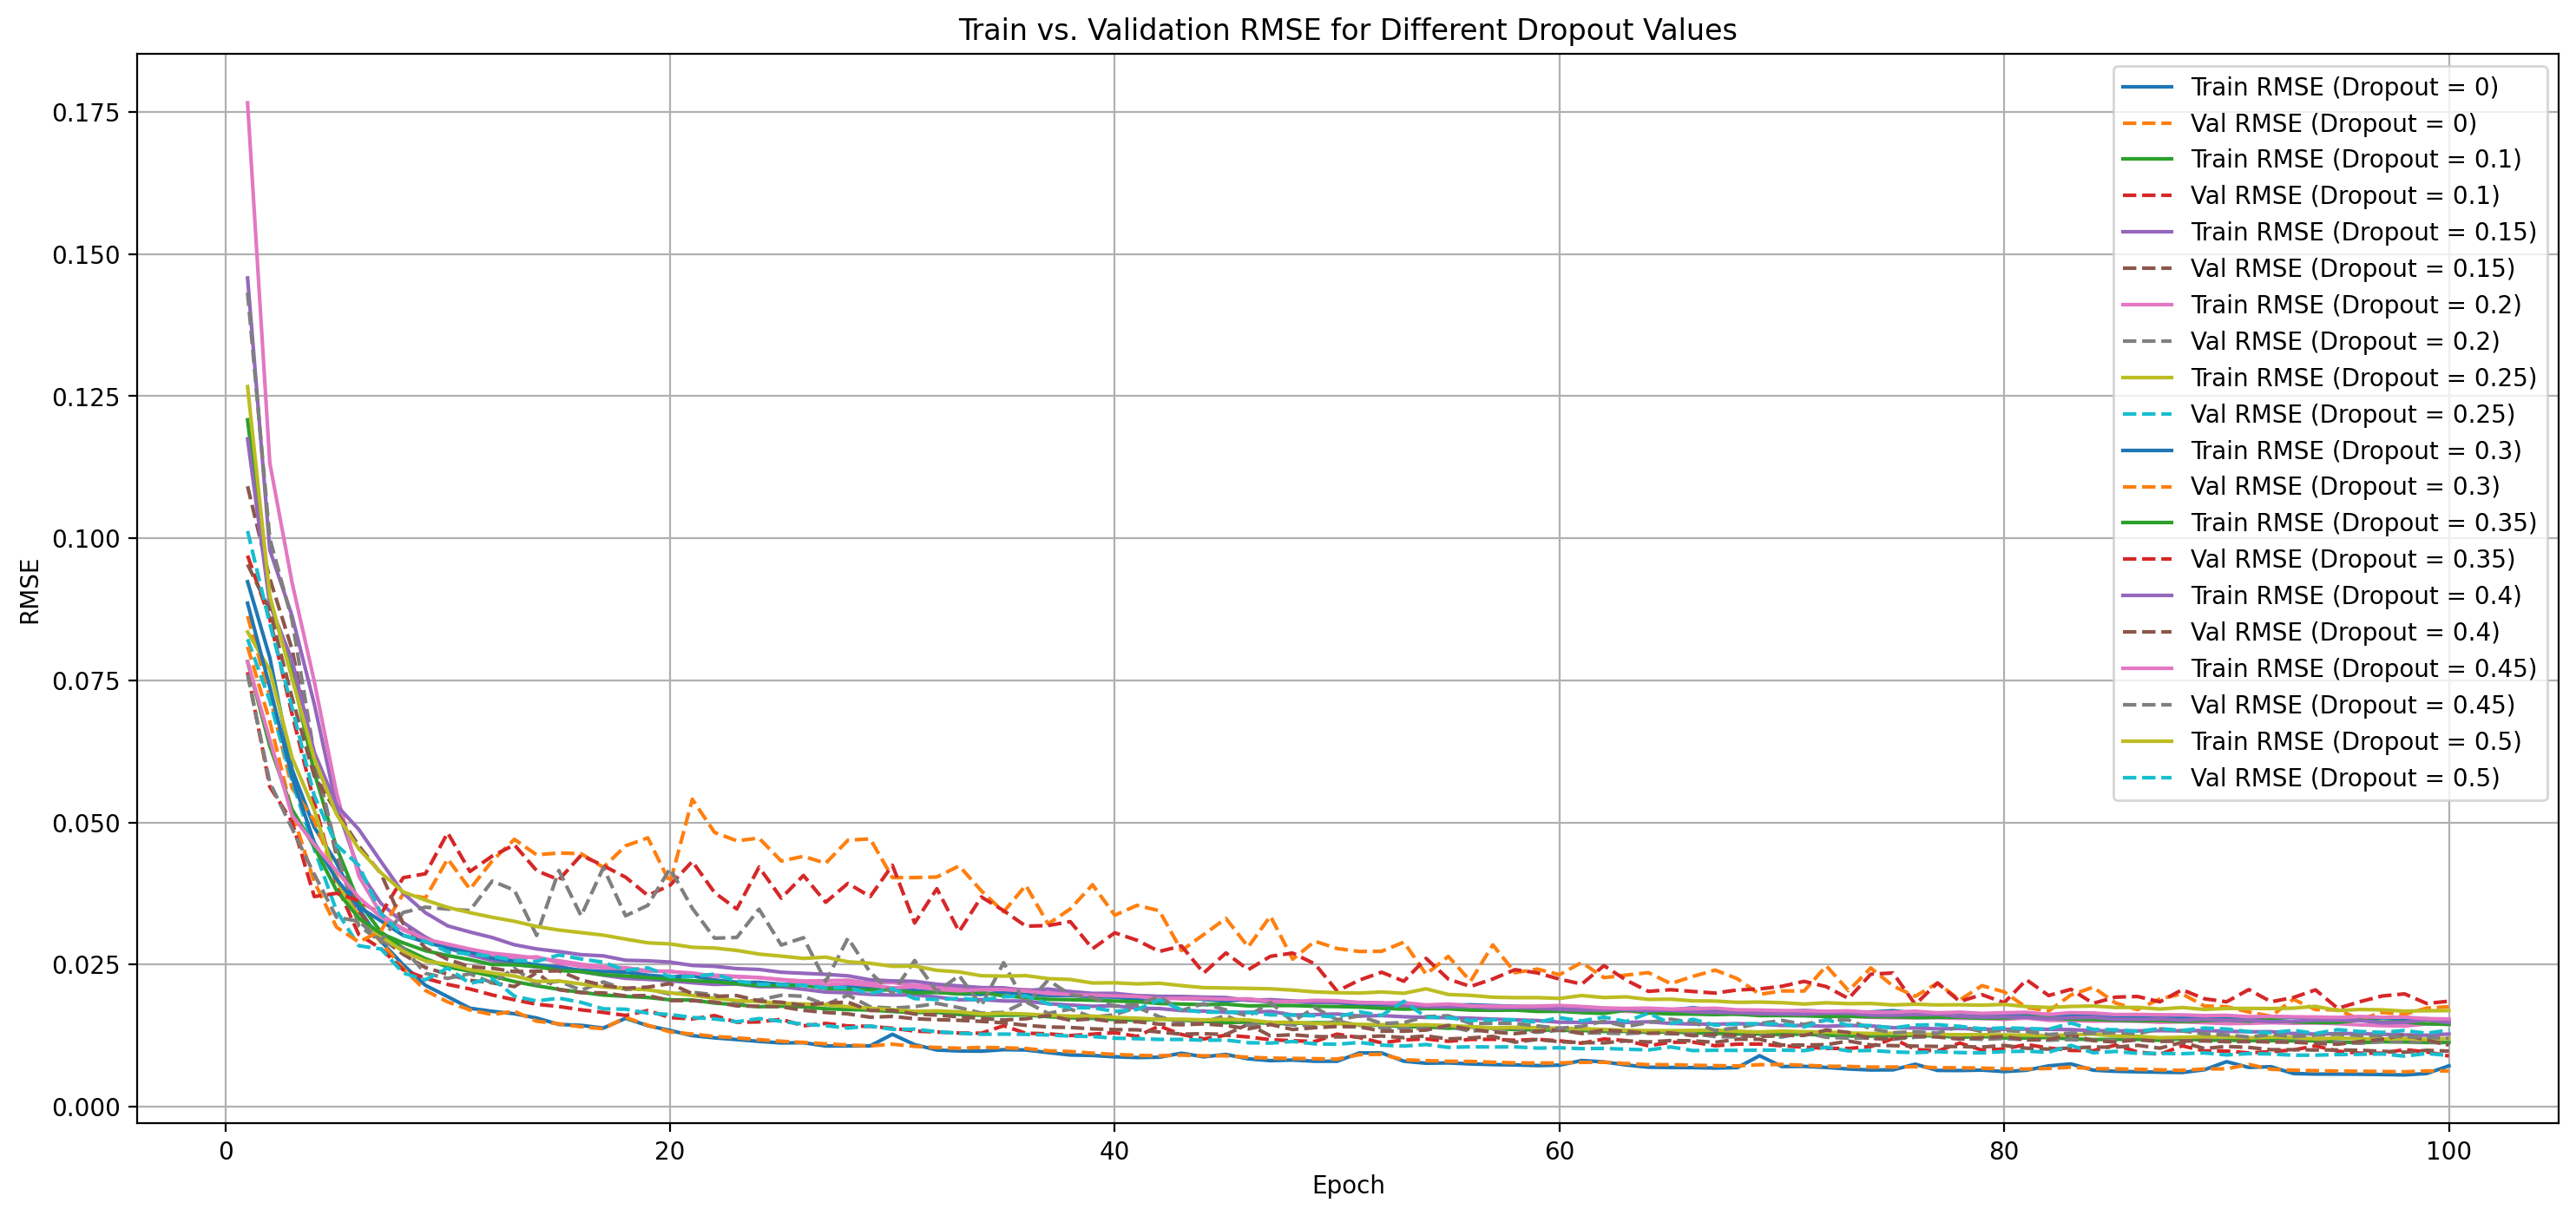

In [11]:
# Plot 3: Both Training and Validation RMSE
plt.figure(figsize=(18, 8))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        linestyle="--",
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

In [12]:
sample = test_loader.dataset[0][0][0].unsqueeze(0).to(device)
output = vae_one_tract(test_loader.dataset[0][0][0].unsqueeze(0).to(device))

In [13]:
orig = sample.cpu().detach().numpy()
recon = output.cpu().detach().numpy()

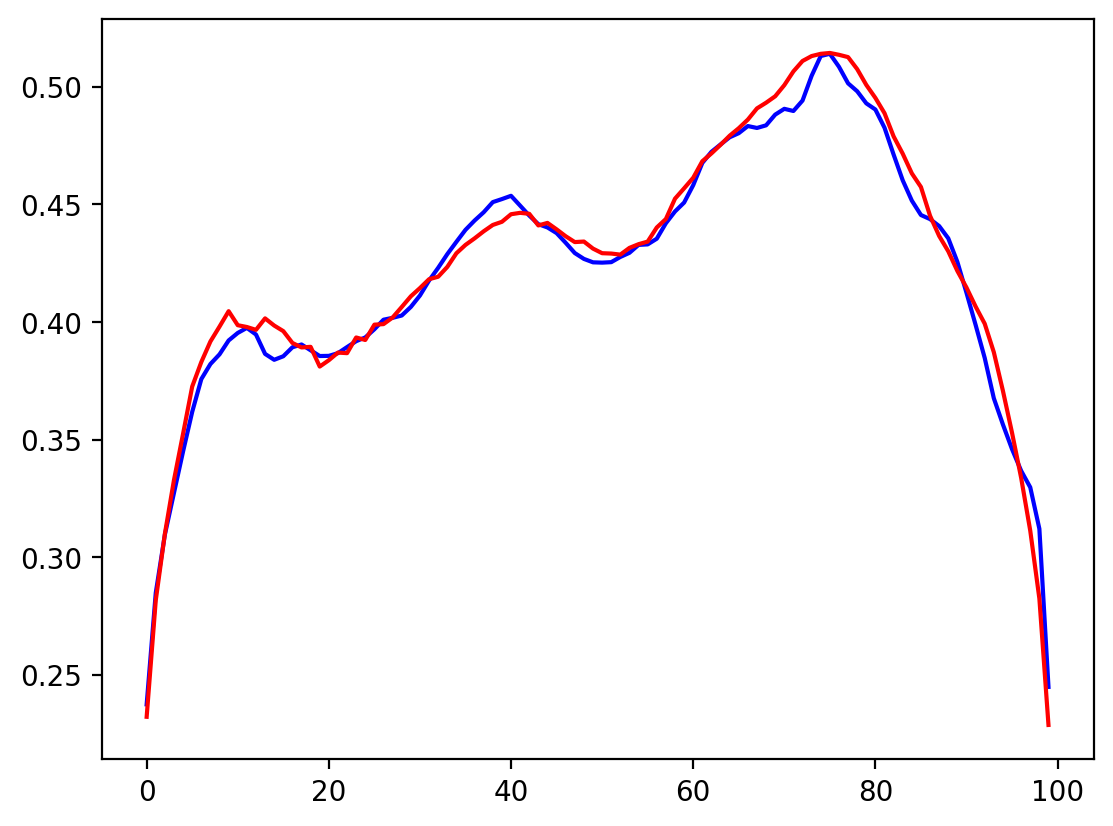

In [14]:
plt.plot(orig.flatten()[0:100], color='blue', label='Original')
plt.plot(recon.flatten()[0:100], color='red', label='Reconstructed')